# Queries to to explore cellular organisation

In [1]:
from py2neo import Graph, Node, Relationship
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from statsmodels.stats import weightstats as stests
import scipy.stats

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-j1y0gi33 because the default path (/home/mario/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# establishing connection with the database

graphHost='localhost'
graphUser = "neo4j"
graphPassphrase = "admin"

graph=Graph(bolt=True, host=graphHost, user=graphUser, password=graphPassphrase)



In [3]:
# scale to show statical significance difference
def stars(p):
   if p < 0.0001:
       return "****"
   elif (p < 0.001):
       return "***"
   elif (p < 0.01):
       return "**"
   elif (p < 0.05):
       return "*"
   else:
       return "-"

# count number of cells

### count total number of cells by slide

Text(0, 0.5, 'Frequency')

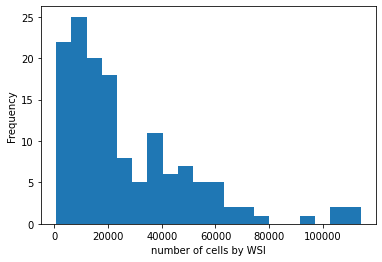

In [87]:
query=graph.run('MATCH (n)'
              'RETURN DISTINCT n.sample, '
              'count(*) AS SampleSize')

result_query=[]
for i in query:

    result_query.append(i)


df=pd.DataFrame(result_query)
df.columns=['sample','count']

cell_count_dic=pd.Series(df['count'].values,index=df['sample']).to_dict()

plt.hist(df['count'].values, bins = 20)
plt.xlabel('number of cells by WSI')
plt.ylabel('Frequency')





### count total number of cells  for each the slides

In [18]:
high_group_query=graph.run('MATCH (n {inmune039:1})'
          'RETURN DISTINCT n.sample, '
          'count(*) AS SampleSize,'
          'avg(size( (n)-[]-() ) ) as Avg_RelationshipCount,'
          'min(size( (n)-[]-() ) ) as Min_RelationshipCount,'
          'max(size( (n)-[]-() ) ) as Max_RelationshipCount')

result_query=[]
for i in high_group_query:
    result_query.append(i)
    
df=pd.DataFrame(result_query)
df.columns=['sample','cells_count','Avg_RelationshipCount','Min_RelationshipCount','Max_RelationshipCount']
df['label']=1

low_group_query=graph.run('MATCH (n {inmune039:0})'
          'RETURN DISTINCT n.sample, '
          'count(*) AS SampleSize,'
          'avg(size( (n)-[]-() ) ) as Avg_RelationshipCount,'
          'min(size( (n)-[]-() ) ) as Min_RelationshipCount,'
          'max(size( (n)-[]-() ) ) as Max_RelationshipCount')
result_query=[]
for i in low_group_query:
    result_query.append(i)
    
temp_df=pd.DataFrame(result_query)

temp_df.columns=['sample','cells_count','Avg_RelationshipCount','Min_RelationshipCount','Max_RelationshipCount']
temp_df['label']=0
df=df.append(temp_df, ignore_index=True)

df


,sample,cells_count,Avg_RelationshipCount,Min_RelationshipCount,Max_RelationshipCount,label
0,test_TCGA-AA-3518-01A-01-BS1,43732,2.633266,0,17,1
1,test_TCGA-AA-3815-01A-01-BS1,46496,2.551058,0,14,1
2,test_TCGA-CM-6172-01A-01-BS1,56905,2.996679,0,16,1
3,test_TCGA-CK-6748-01A-01-TS1,5950,1.208067,0,9,1
4,test_TCGA-CM-5863-01A-01-BS1,20526,1.812823,0,12,1
...,...,...,...,...,...,...
105,test_TCGA-AA-A00W-01A-01-BS1,2385,2.195388,0,12,0
106,train_TCGA-CM-6676-01A-01-TS1,102764,3.586762,0,15,0
107,valid_TCGA-CM-6675-01A-01-TS1,114041,3.337309,0,15,0
108,valid_TCGA-CM-6675-01A-01-BS1,91462,1.924603,0,16,0


### count number of each type cells for each slide

In [19]:
cells=['misc','lymph','tumor','stroma']
for cell in cells:
    
    print('type of cell: '+cell)
    query=graph.run('MATCH (n:'+cell+')'
                  'RETURN DISTINCT n.sample, '
                  'count(*) AS SampleSize')
    
    result_query=[]
    for i in query:
        result_query.append(i)
 
    df=pd.DataFrame(result_query)

    df.columns=['sample','count']


    globals()[cell +"_count_dic"] =pd.Series(df['count'].values,index=df['sample']).to_dict()


    

type of cell: misc
type of cell: lymph
type of cell: tumor
type of cell: stroma


### analysing volume of cell populations for the high and low immune groups

*************** misc
count_corrected
mean_cluster0 0.6752641806799978
mean_cluster1 0.6849966552144475


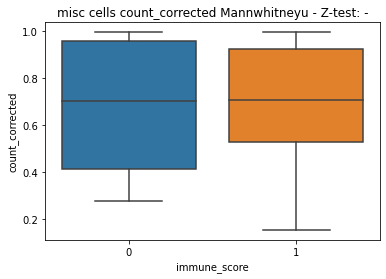

*************** lymph
count_corrected
mean_cluster0 0.06116181615187815
mean_cluster1 0.06191466293002735


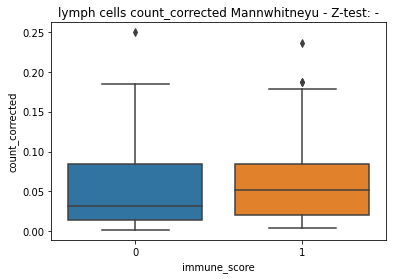

*************** tumor
count_corrected
mean_cluster0 0.1799420947680475
mean_cluster1 0.1479061350328562


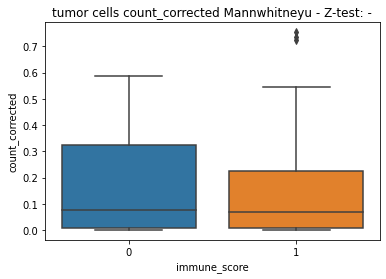

*************** stroma
count_corrected
mean_cluster0 0.09112949568207851
mean_cluster1 0.11164020508056575


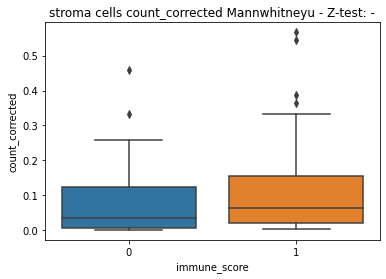

In [108]:
cells=['misc','lymph','tumor','stroma']
for c,cell in enumerate(cells):
    
    print('*************** '+cell)

    high_group_query=graph.run('MATCH (n:'+cell+' {inmune039:1})'
              'RETURN DISTINCT n.sample, '
              'count(*) AS SampleSize,'
              'avg(size( (n)-[]-() ) ) as Avg_RelationshipCount,'
              'min(size( (n)-[]-() ) ) as Min_RelationshipCount,'
              'max(size( (n)-[]-() ) ) as Max_RelationshipCount')

    result_query=[]
    for i in high_group_query:
        result_query.append(i)
        

    df=pd.DataFrame(result_query)
    df.columns=['sample','count','Avg_RelationshipCount','Min_RelationshipCount','Max_RelationshipCount']
    df['immune_score']=1




    low_group_query=graph.run('MATCH (n:'+cell+' {inmune039:0})'
              'RETURN DISTINCT n.sample, '
              'count(*) AS SampleSize,'
              'avg(size( (n)-[]-() ) ) as Avg_RelationshipCount,'
              'min(size( (n)-[]-() ) ) as Min_RelationshipCount,'
              'max(size( (n)-[]-() ) ) as Max_RelationshipCount')
    result_query=[]
    for i in low_group_query:
        result_query.append(i)
    
    temp_df=pd.DataFrame(result_query)

    temp_df.columns=['sample','count','Avg_RelationshipCount','Min_RelationshipCount','Max_RelationshipCount']
    temp_df['immune_score']=0
    df=df.append(temp_df, ignore_index=True)
    
    
    df['count_corrected']=df['count']/( df['sample'].map(cell_count_dic))
  
  


    features=['count_corrected']
    for i,feature in enumerate(features):
        
        # Mann Whitneyu test
        z, p = scipy.stats.mannwhitneyu(df[feature][df["immune_score"]==0].values, df[feature][df["immune_score"]==1].values)

        mean_cluster0=np.mean(df[feature][df["immune_score"]==0].values)
        mean_cluster1=np.mean(df[feature][df["immune_score"]==1].values)

        print(features[i])
        print('mean_cluster0 '+str(mean_cluster0))
        print('mean_cluster1 '+str(mean_cluster1))

        # Z-test
        ztest ,pval1 = stests.ztest(df[feature][df["immune_score"]==0].values, df[feature][df["immune_score"]==1].values,value=0,alternative='two-sided')

        title=cell+" cells "+features[i]+" Mannwhitneyu "+stars(p)+" Z-test: "+stars(pval1)

        ax = sns.boxplot(x="immune_score",y=feature,data=df).set_title(title)
        plt.show()
        plt.close()




    

# count number of relations

### count number of total relations for each slide

Text(0, 0.5, 'Frequency')

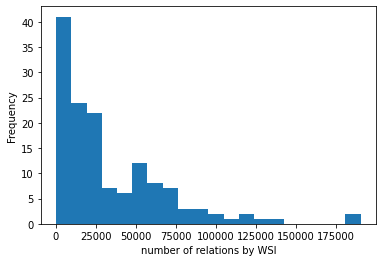

In [89]:
query=graph.run('MATCH (n)-[]->()  '
                   'RETURN  DISTINCT n.sample, '
              'count(*) AS count')


result_query=[]
for i in query:
    result_query.append(i)
 
df=pd.DataFrame(result_query)

df.columns=['sample','count']
relation_count_dic=pd.Series(df['count'].values,index=df['sample']).to_dict()

plt.hist(df['count'].values, bins = 20)
plt.xlabel('number of relations by WSI')
plt.ylabel('Frequency')

### count number of each type of relations for each slide

In [28]:
relations=['misc-misc',
'tumor-tumor',
'stroma-stroma',
'misc-tumor',
'misc-lymph',
'lymph-lymph',
'misc-stroma',
'lymph-stroma',
'lymph-tumor',
'stroma-tumor']
for relation in relations:
    
    print('type of relation: '+relation)
    query=graph.run('MATCH (n )-[r:`'+relation+'`]->()  '
                   'RETURN  DISTINCT n.sample, '
              'count(*) AS count')
    
    
    result_query=[]
    for i in query:
        result_query.append(i)
    
    df=pd.DataFrame(result_query)

    df.columns=['sample','count']


    globals()[relation +"_count_dic"] =pd.Series(df['count'].values,index=df['sample']).to_dict()


type of relation: misc-misc
type of relation: tumor-tumor
type of relation: stroma-stroma
type of relation: misc-tumor
type of relation: misc-lymph
type of relation: lymph-lymph
type of relation: misc-stroma
type of relation: lymph-stroma
type of relation: lymph-tumor
type of relation: stroma-tumor


### analysing volume of relations populations for the high and low immune groups

*************** misc-tumor
count_corrected
mean_cluster0 0.6053777146857611
mean_cluster1 0.6513352540963483


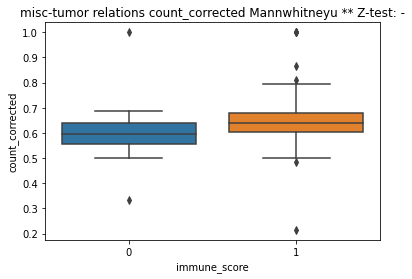

*************** misc-lymph
count_corrected
mean_cluster0 0.46951748387547987
mean_cluster1 0.5245032399992706


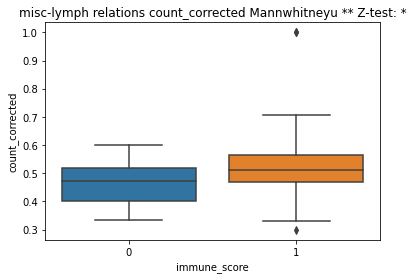

*************** misc-stroma
count_corrected
mean_cluster0 0.5451596289692335
mean_cluster1 0.5953264498566416


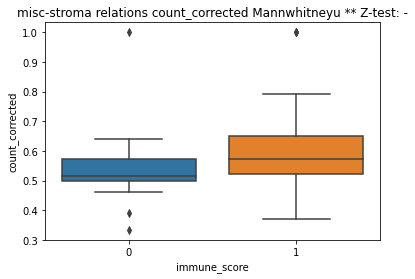

*************** lymph-stroma
count_corrected
mean_cluster0 0.5732908577025223
mean_cluster1 0.6045900914778085


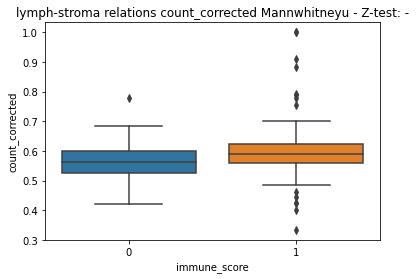

*************** lymph-tumor
count_corrected
mean_cluster0 0.7185649330746062
mean_cluster1 0.8078936341746655


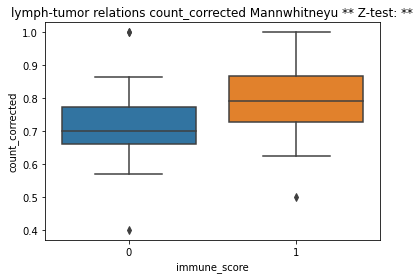

*************** stroma-tumor
count_corrected
mean_cluster0 0.6566466562980212
mean_cluster1 0.7107489769694533


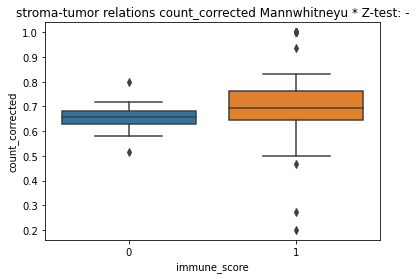

In [107]:


relations=[
'misc-tumor',
'misc-lymph',
'misc-stroma',
'lymph-stroma',
'lymph-tumor',
'stroma-tumor']


for relation in relations:
    cell1=relation.split('-')[0]
    cell2=relation.split('-')[1]
    
    print('*************** '+relation)

    high_group_query=graph.run('MATCH (n:'+cell1+' {inmune039:1})-[r:`'+relation+'`]->(b:'+cell2+' {inmune039:1})  '
                'RETURN  DISTINCT n.sample, '
                'count(*) AS count')

    result_query=[]
    for i in high_group_query:
        result_query.append(i)
        

    df=pd.DataFrame(result_query)
    df.columns=['sample','count']
    df['immune_score']=1


    

    low_group_query=graph.run('MATCH (n:'+cell1+' {inmune039:0})-[r:`'+relation+'`]->(b:'+cell2+' {inmune039:0})  '
                   'RETURN  DISTINCT n.sample, '
              'count(*) AS count')
    result_query=[]
    for i in low_group_query:

        result_query.append(i)
        #print(i)
    temp_df=pd.DataFrame(result_query)

    temp_df.columns=['sample','count']
    temp_df['immune_score']=0
    df=df.append(temp_df, ignore_index=True)
   
    df['count_corrected']=df['count']/( df['sample'].map(globals()[relation+'_count_dic']))


    features=['count_corrected']
    for i,feature in enumerate(features):
        
        # Mann Whitneyu test
        z, p = scipy.stats.mannwhitneyu(df[feature][df["immune_score"]==0].values, df[feature][df["immune_score"]==1].values)

        mean_cluster0=np.mean(df[feature][df["immune_score"]==0].values)
        mean_cluster1=np.mean(df[feature][df["immune_score"]==1].values)

        print(features[i])
        print('mean_cluster0 '+str(mean_cluster0))
        print('mean_cluster1 '+str(mean_cluster1))

        # Z-test
        ztest ,pval1 = stests.ztest(df[feature][df["immune_score"]==0].values, df[feature][df["immune_score"]==1].values,value=0,alternative='two-sided')

        title=relation+" relations "+features[i]+" Mannwhitneyu "+stars(p)+" Z-test: "+stars(pval1)

        ax = sns.boxplot(x="immune_score",y=feature,data=df).set_title(title)
        plt.show()
        plt.close()




     




    

# count number cells without relations

type of cell: misc
count_corrected
mean_cluster0 0.31948996396115276
mean_cluster1 0.2779246023022281


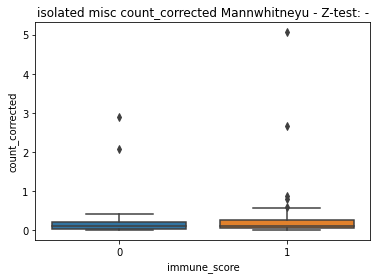

type of cell: lymph
count_corrected
mean_cluster0 0.009263073434625761
mean_cluster1 0.016570444131635945


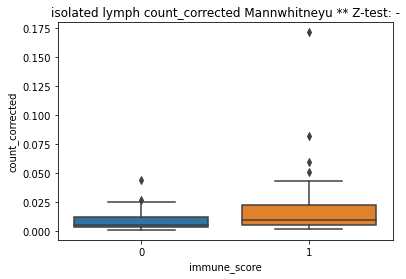

type of cell: tumor
count_corrected
mean_cluster0 0.014418660429508403
mean_cluster1 0.009956906036777702


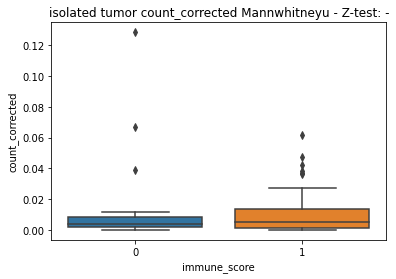

type of cell: stroma
count_corrected
mean_cluster0 0.016938710530367634
mean_cluster1 0.03230271897068709


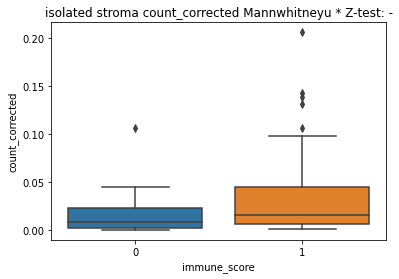

In [106]:
cells=['misc','lymph','tumor','stroma']
for cell in cells:
    
    print('type of cell: '+cell)
    high_group_query=graph.run('MATCH (n:'+cell+' {inmune039:1}) WHERE NOT (n)--()'
              'RETURN DISTINCT n.sample, '
              'count(*) AS SampleSize')

    result_query=[]
    for i in high_group_query:
        result_query.append(i)


    df=pd.DataFrame(result_query)

    df.columns=['sample','count']
    df['immune_score']=1

    


    low_group_query=graph.run('MATCH (n:'+cell+' {inmune039:0}) WHERE NOT (n)--()'
              'RETURN DISTINCT n.sample, '
              'count(*) AS SampleSize')
    result_query=[]
    for i in low_group_query:
        result_query.append(i)
    
    temp_df=pd.DataFrame(result_query)

    temp_df.columns=['sample','count']
    temp_df['immune_score']=0
    df=df.append(temp_df, ignore_index=True)
    
    
    
    df['count_corrected']=df['count']/( df['sample'].map(relation_count_dic))

    Mannwhitneyu_values=[]
    Ztest_values=[]


    features=['count_corrected']
    for i,feature in enumerate(features):
        
        # Mann Whitneyu test
        z, p = scipy.stats.mannwhitneyu(df[feature][df["immune_score"]==0].values, df[feature][df["immune_score"]==1].values)

        mean_cluster0=np.mean(df[feature][df["immune_score"]==0].values)
        mean_cluster1=np.mean(df[feature][df["immune_score"]==1].values)

        print(features[i])
        print('mean_cluster0 '+str(mean_cluster0))
        print('mean_cluster1 '+str(mean_cluster1))

        # Z-test
        ztest ,pval1 = stests.ztest(df[feature][df["immune_score"]==0].values, df[feature][df["immune_score"]==1].values,value=0,alternative='two-sided')

        title="isolated "+cell+" "+features[i]+" Mannwhitneyu "+stars(p)+" Z-test: "+stars(pval1)

        ax = sns.boxplot(x="immune_score",y=feature,data=df).set_title(title)
        plt.show()
        plt.close()




    

# analysing stroma barriers

count_corrected
mean_cluster0 0.005307361582971188
mean_cluster1 0.0029659190649063065


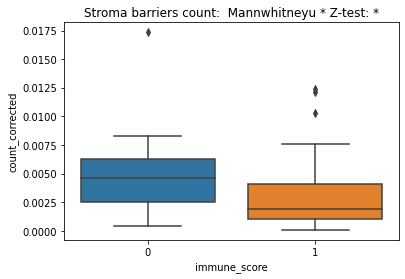

count
mean_cluster0 130.0
mean_cluster1 50.735849056603776


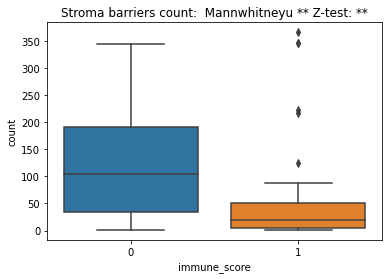

In [105]:

    


high_group_query=graph.run('MATCH (a:lymph {inmune039:1})-[r:`lymph-stroma`]->(b:stroma)-[s:`stroma-tumor`]-(c:tumor)'
          'RETURN DISTINCT a.sample, '
          'count(*) AS SampleSize')


result_query=[]
for i in high_group_query:
    result_query.append(i)
    

df=pd.DataFrame(result_query)

df.columns=['sample','count']
df['immune_score']=1




low_group_query=graph.run('MATCH (a:lymph {inmune039:0})-[r:`lymph-stroma`]->(b:stroma)-[s:`stroma-tumor`]-(c:tumor)'
          'RETURN DISTINCT a.sample, '
          'count(*) AS SampleSize')
result_query=[]
for i in low_group_query:
    result_query.append(i)

temp_df=pd.DataFrame(result_query)

temp_df.columns=['sample','count']
temp_df['immune_score']=0
df=df.append(temp_df, ignore_index=True)

df['count_corrected']=df['count']/(df['sample'].map(stroma_count_dic)+df['sample'].map(tumor_count_dic)+df['sample'].map(lymph_count_dic))


Mannwhitneyu_values=[]
Ztest_values=[]


features=['count_corrected','count']
for i,feature in enumerate(features):

    # Mann Whitneyu test
    z, p = scipy.stats.mannwhitneyu(df[feature][df["immune_score"]==0].values, df[feature][df["immune_score"]==1].values)

    mean_cluster0=np.mean(df[feature][df["immune_score"]==0].values)
    mean_cluster1=np.mean(df[feature][df["immune_score"]==1].values)

    print(features[i])
    print('mean_cluster0 '+str(mean_cluster0))
    print('mean_cluster1 '+str(mean_cluster1))

    # Z-test
    ztest ,pval1 = stests.ztest(df[feature][df["immune_score"]==0].values, df[feature][df["immune_score"]==1].values,value=0,alternative='two-sided')

    title="Stroma barriers count:  Mannwhitneyu "+stars(p)+" Z-test: "+stars(pval1)

    ax = sns.boxplot(x="immune_score",y=feature,data=df).set_title(title)
    plt.show()
    plt.close()




    

# Analysing lymphocites triplets

count_corrected
mean_cluster0 1.372779883094045
mean_cluster1 0.8979259225235872


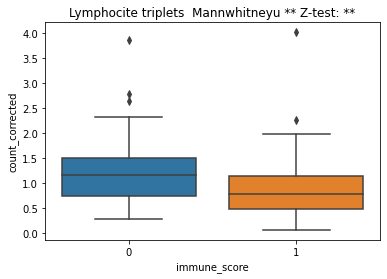

In [104]:

    


high_group_query=graph.run('MATCH (a:lymph{inmune039:1} )-[r:`lymph-lymph`]->(b:lymph{inmune039:1})-[s:`lymph-lymph`]-(c:lymph{inmune039:1})'
          'RETURN DISTINCT a.sample, '
          'count(*) AS SampleSize')


result_query=[]
for i in high_group_query:
    result_query.append(i)


df=pd.DataFrame(result_query)

df.columns=['sample','count']
df['immune_score']=1




low_group_query=graph.run('MATCH (a:lymph {inmune039:0})-[r:`lymph-lymph`]->(b:lymph{inmune039:0})-[s:`lymph-lymph`]-(c:lymph{inmune039:0})'
          'RETURN DISTINCT a.sample, '
          'count(*) AS SampleSize')
result_query=[]
for i in low_group_query:
    result_query.append(i)
 
temp_df=pd.DataFrame(result_query)

temp_df.columns=['sample','count']
temp_df['immune_score']=0
df=df.append(temp_df, ignore_index=True)


relation1="lymph-lymph"
relation2="stroma-tumor"


df['count_corrected']=df['count']/(df['sample'].map(globals()[relation1 +"_count_dic"]))


features=['count_corrected']
for i,feature in enumerate(features):

    # Mann Whitneyu test
    z, p = scipy.stats.mannwhitneyu(df[feature][df["immune_score"]==0].values, df[feature][df["immune_score"]==1].values)

    mean_cluster0=np.mean(df[feature][df["immune_score"]==0].values)
    mean_cluster1=np.mean(df[feature][df["immune_score"]==1].values)

    print(features[i])
    print('mean_cluster0 '+str(mean_cluster0))
    print('mean_cluster1 '+str(mean_cluster1))

    # Z-test
    ztest ,pval1 = stests.ztest(df[feature][df["immune_score"]==0].values, df[feature][df["immune_score"]==1].values,value=0,alternative='two-sided')

    title="Lymphocite triplets  Mannwhitneyu "+stars(p)+" Z-test: "+stars(pval1)

    ax = sns.boxplot(x="immune_score",y=feature,data=df).set_title(title)
    plt.show()
    plt.close()


    

# Analysing stroma triplets

count_corrected
mean_cluster0 0.39073236529505256
mean_cluster1 0.3165738893620386


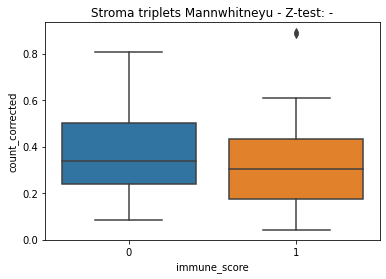

In [103]:

    


low_group_query=graph.run('MATCH (a:stroma {inmune039:1})-[r:`stroma-stroma`]->(b:stroma)-[s:`stroma-stroma`]->(c:stroma)'
          'RETURN DISTINCT a.sample, '
          'count(*) AS SampleSize')


result_query=[]
for i in low_group_query:
    result_query.append(i)
    #print(i)

df=pd.DataFrame(result_query)

df.columns=['sample','count']
df['immune_score']=1




low_group_query=graph.run('MATCH (a:stroma {inmune039:0})-[r:`stroma-stroma`]->(b:stroma)-[s:`stroma-stroma`]->(c:stroma)'
          'RETURN DISTINCT a.sample, '
          'count(*) AS SampleSize')
result_query=[]
for i in low_group_query:

    result_query.append(i)
    #print(i)
temp=pd.DataFrame(result_query)

temp.columns=['sample','count']
temp['immune_score']=0
df=df.append(temp, ignore_index=True)



relation1="stroma-stroma"
df['count_corrected']=df['count']/(df['sample'].map(globals()[relation1 +"_count_dic"]))




features=['count_corrected']
for i,feature in enumerate(features):

    # Mann Whitneyu test
    z, p = scipy.stats.mannwhitneyu(df[feature][df["immune_score"]==0].values, df[feature][df["immune_score"]==1].values)

    mean_cluster0=np.mean(df[feature][df["immune_score"]==0].values)
    mean_cluster1=np.mean(df[feature][df["immune_score"]==1].values)

    print(features[i])
    print('mean_cluster0 '+str(mean_cluster0))
    print('mean_cluster1 '+str(mean_cluster1))

    # Z-test
    ztest ,pval1 = stests.ztest(df[feature][df["immune_score"]==0].values, df[feature][df["immune_score"]==1].values,value=0,alternative='two-sided')

    title="Stroma triplets Mannwhitneyu "+stars(p)+" Z-test: "+stars(pval1)

    ax = sns.boxplot(x="immune_score",y=feature,data=df).set_title(title)
    plt.show()
    plt.close()
